# Analyzing Phase 4 Tasks in Construction Project

This notebook focuses on the data analysis of Phase 4 tasks in a construction project. We will import and clean the data, then conduct several exploratory data analysis steps to understand the distribution and time spent on various tasks. Finally, we will visualize our findings.

## Table of Contents
1. [Imports and Data Loading](#Imports-and-Data-Loading)
2. [Data Cleaning and Transformation](#Data-Cleaning-and-Transformation)
3. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis)
    - [Overview of Data](#Overview-of-Data)
    - [Tasks Analysis](#Tasks-Analysis)
    - [Time Analysis](#Time-Analysis)
4. [Visualizations](#Visualizations)
    - [Hours and Weeks by Task](#Hours-and-Weeks-by-Task)
    - [Sum of Hours per Week](#Sum-of-Hours-per-Week)
5. [Overtime EDA](#Overtime-Analysis)
    - [Weekly Data Transformation](#Weekly-Data-Transformation)
6. [OT Visualizations](#OT-Visualizations)
    - [Hours and Weeks by Task](#Hours-and-Weeks-by-Task)
    - [Weekly Overtime hours and Regular hours per Employee](#Weekly-Overtime-hours-and-Regular-hours-per-Employee)
7. [Conclusion](#Conclusion)
---

## Imports and Data Loading
In this section, we import the necessary libraries and load the Phase 4 dataset from an Excel file.


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import re #regex

In [34]:
#Create phase 4 DF 
phase4_df = pd.read_excel('C:\\Users\\David\\Downloads\\Phase 4\\excel\\Phase4.xlsx')

## Data Cleaning and Transformation

We will transform and clean the dataset to make it suitable for analysis. The following steps are performed:

1. Convert the 'Hours' column from HH:MM:SS format to hours in decimal form.
2. Convert the 'Date' column to datetime format.
3. Create new columns for 'Year', 'Week', and 'Weeks'.
4. Group all unspecified tasks into a single category: 'Prime and Touch ups'.
5. Remove rows with tasks that are not specified in our task list.

Let's start by defining the array of tasks to clean up and then apply the transformations.

In [35]:
#Array of all tasks that were not specified in odoo
badtsk = ['/', 'Final touch ups','trim, caulk, prime,',
       'Trim, caulk, touch ups,']

#Transforming and cleaning the dataframe
phase4_df =( 
    phase4_df.assign(
        # Converting the 'Hours' column from HH:MM:SS to hours in decimal form
        Hours = lambda data : (
            pd.to_timedelta(data['Hours'].astype(str))
            .dt.total_seconds() / 3600
        ),
        # Converting 'Date' column to datetime
        Date = lambda data :  pd.to_datetime(
            data['Date'], format='%m/%d/%Y'
                
        ),
        # Creating 'Year' and 'Week' columns
        Year = lambda data : (
            data['Date']
            .dt.year
        ),
        Week = lambda data : (
            data['Date']
            .dt.isocalendar().week
        ),
        Weeks = lambda data : (
            data['Date'].dt.strftime('%Y-%U')
        ),
        #Grouping all the kind of loose tasks into one section Prime and Touch ups
        Task = lambda data : (
            data['Task'].replace(badtsk,'Prime and Touch ups')
        )
    )
)

In [36]:
phase4_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         220 non-null    datetime64[ns]
 1   Employee     220 non-null    object        
 2   Task         219 non-null    object        
 3   Description  154 non-null    object        
 4   Hours        220 non-null    float64       
 5   Year         220 non-null    int32         
 6   Week         220 non-null    UInt32        
 7   Weeks        220 non-null    object        
dtypes: UInt32(1), datetime64[ns](1), float64(1), int32(1), object(4)
memory usage: 12.4+ KB


## Exploratory Data Analysis (EDA)

### Overview of Data

First, let's take a look at the summary of our cleaned dataset.

In [39]:
phase4_df['Task'].unique()

array(['Prime and Touch ups', nan, 'Drywall', 'Concrete Floor',
       'Insulation', 'Interior Framing', 'Electrical', 'Plumbing'],
      dtype=object)

### Tasks Analysis

We'll filter out any invalid tasks and focus on the specified tasks in our analysis.

In [41]:
tasks = phase4_df['Task'].unique()
# Using list comprehension to filter out bad tasks
tasks = [task for task in tasks if task in tasks]

# Convert list to array
tasks_array = np.array(tasks)

# Create a mask for non-NaN values
mask = np.array([task != 'nan' for task in tasks_array])

# Apply the mask to get only non-NaN values
tasks = tasks_array[mask]

In [42]:
# Get the rows from the phase4_df where Task column contains values that exists in the tasks array
phase4_df = phase4_df[phase4_df['Task'].isin(tasks)]

In [43]:
#Create variables to get the no. of weeks and the total of hours
phase4_total_weeks = phase4_df['Weeks'].nunique()

phase4_total_hours = phase4_df['Hours'].sum()

### Time Analysis

Now, we will calculate the total number of weeks and hours spent on tasks during Phase 4.

In [44]:
#Calculate Hours per Task
total_hours = phase4_df.groupby('Task')['Hours'].sum().reset_index()
total_hours.columns = ['Task','Hours']

#Calculate Weeks per Task
total_weeks = phase4_df.groupby('Task')['Weeks'].nunique().reset_index()
total_weeks.columns = ['Task','Weeks']

#Get first date per Task
start_date = phase4_df.groupby('Task')['Date'].min().reset_index()
start_date.columns = ['Task','Start Date']

#Get the last date per Task
end_date = phase4_df.groupby('Task')['Date'].max().reset_index()
end_date.columns = ['Task','End Date']

#Merge the two calculations
hour_week_df = pd.merge(total_hours,total_weeks, on='Task')
hour_week_df = pd.merge(hour_week_df,start_date, on='Task')
hour_week_df = pd.merge(hour_week_df,end_date, on='Task')
hour_week_df = hour_week_df.sort_values(by='Start Date')
hour_week_df.style

,Task,Hours,Weeks,Start Date,End Date
5,Plumbing,50.000000,3,2023-06-29 00:00:00,2023-07-10 00:00:00
0,Concrete Floor,120.000000,3,2023-07-04 00:00:00,2023-07-20 00:00:00
4,Interior Framing,505.000000,13,2023-07-31 00:00:00,2024-04-11 00:00:00
2,Electrical,6.000000,1,2023-08-30 00:00:00,2023-08-30 00:00:00
3,Insulation,114.000000,4,2023-12-04 00:00:00,2024-01-17 00:00:00
1,Drywall,577.750000,14,2024-01-02 00:00:00,2024-05-27 00:00:00
6,Prime and Touch ups,688.500000,8,2024-04-24 00:00:00,2024-06-12 00:00:00


## Visualizations

### Hours and Weeks by Task

We will create a bar plot to show the total hours and weeks spent on each task during Phase 4.

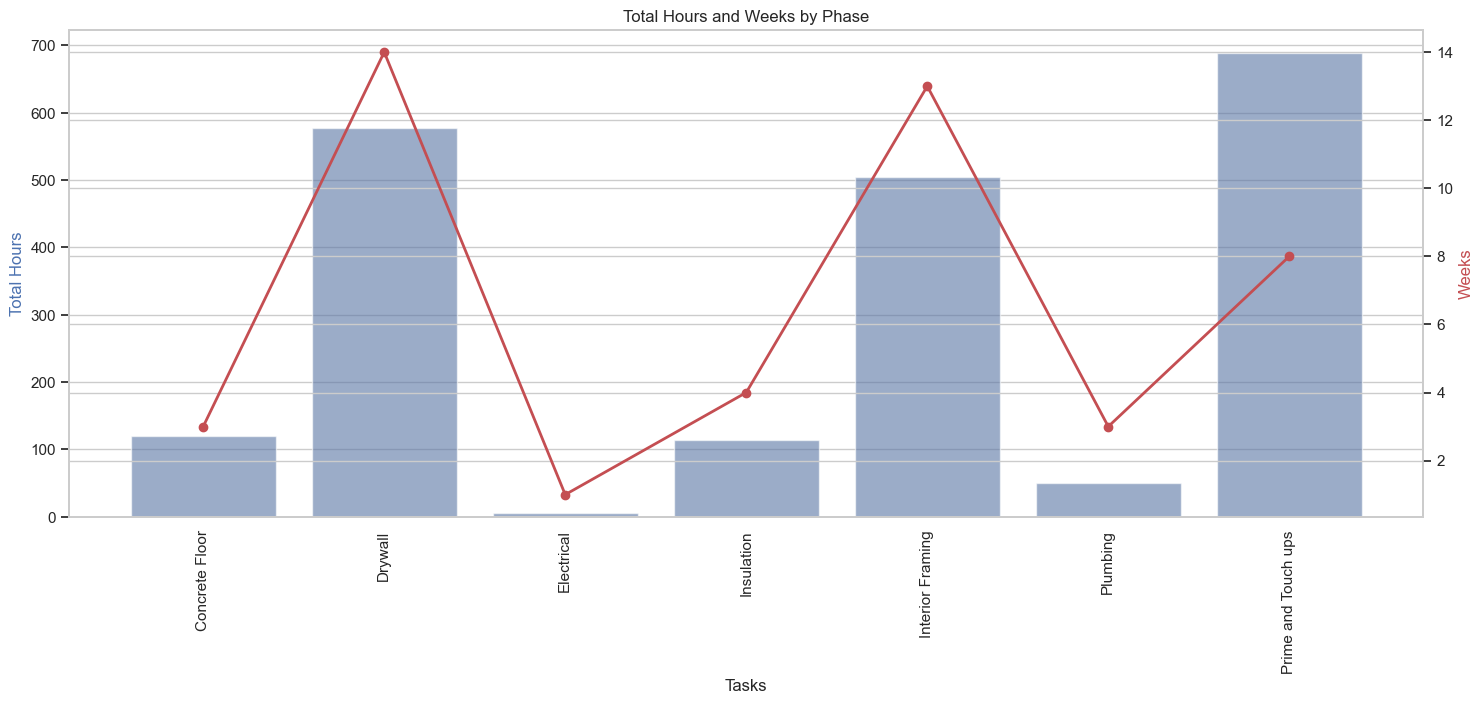

In [45]:
#Plot
# Set the seaborn style
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot the bar chart on ax1
sns.barplot(x='Task', y='Hours',data=total_hours, ax=ax1, color='b', alpha=0.6)

# Set labels for the first y-axis
ax1.set_ylabel('Total Hours', color='b')
ax1.set_xlabel('Tasks')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# Create a second y-axis to plot the weeks
ax2 = ax1.twinx()
ax2.plot(total_weeks['Task'], total_weeks['Weeks'], color='r', marker='o', linewidth=2)

# Set labels for the second y-axis
ax2.set_ylabel('Weeks', color='r')
plt.tight_layout()

# Show the plot
plt.title('Total Hours and Weeks by Phase')
plt.show()

<center> All tasks had a similar weeks to human hours proportion, except for Prime and Tocuh ups during this task there was a 
higher proportion of hours to weeks.<center>

--------------------

### Sum of Hours per Week

Next, we will create a bar plot to show the sum of hours spent on each task for each week.

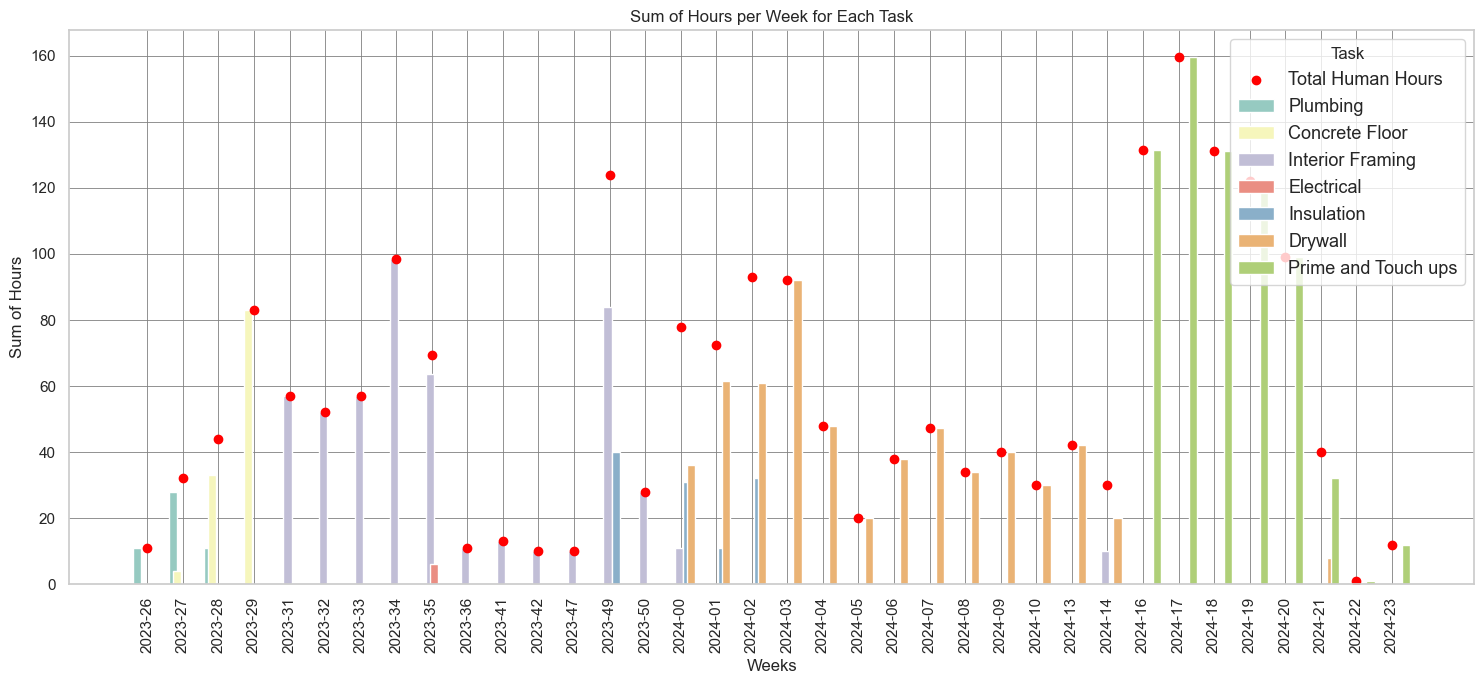

In [46]:
# Grouping by both 'Week' and 'Task' and aggregating hours
grouped_df = phase4_df.groupby(['Weeks', 'Task'])['Hours'].sum().reset_index()

# Plotting
plt.figure(figsize=(15, 7))
sns.barplot(x='Weeks', y='Hours', hue='Task', data=grouped_df, palette='Set3')

# Adjusting bar width using matplotlib after seaborn plot
for patch in plt.gca().patches:
    current_width = patch.get_width()
    diff = current_width * 1  
    patch.set_width(current_width + diff)

#Calculate the sum of hours per week not task!!    
phase4_time_df= phase4_df.groupby('Weeks')["Hours"].sum().reset_index()    
plt.scatter(phase4_time_df['Weeks'], phase4_time_df['Hours'], color='red', label='Total Human Hours')


plt.title('Sum of Hours per Week for Each Task')
plt.xticks(rotation=90)
plt.xlabel('Weeks')
plt.ylabel('Sum of Hours')
plt.legend(title='Task', loc='upper right', fontsize="13")
plt.grid(color = 'gray', linestyle = '-', linewidth = 0.6)
plt.tight_layout()
plt.show()

<center>There was only a significand overlap during the Interior Framing, Insulation and Drywall tasks, as expected<center>

### Zoom on the most overlaped weeks / tasks


In [47]:
#Select data from tasks in di 
di = ['Interior Framing', 'Insulation','Drywall']
di_df = grouped_df.loc[grouped_df["Task"].isin(di)]


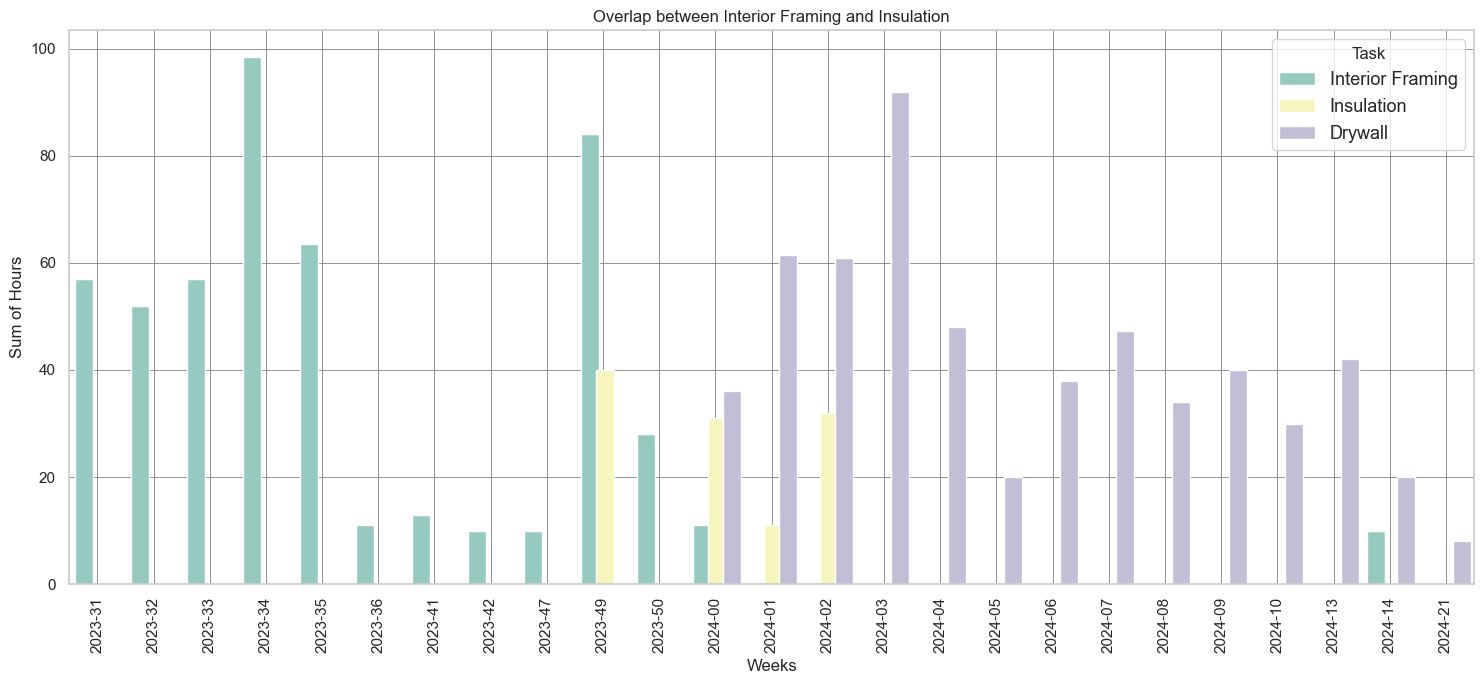

In [48]:
# Plotting overlap 
plt.figure(figsize=(15, 7))
sns.barplot(x='Weeks', y='Hours', hue='Task', data=di_df, palette='Set3')

# Adjusting bar width using matplotlib after seaborn plot
for patch in plt.gca().patches:
    current_width = patch.get_width()
    diff = current_width * 0.2  
    patch.set_width(current_width + diff)

plt.title('Overlap between Interior Framing and Insulation')
plt.xticks(rotation=90)
plt.xlabel('Weeks')
plt.ylabel('Sum of Hours')
plt.legend(title='Task', loc='upper right', fontsize="13")
plt.grid(color = 'gray', linestyle = '-', linewidth = 0.6)
plt.tight_layout()
plt.show()

<center>Here we have zoomed on the overlaped weeks, this is a normal behaviour during these tasks<center>

----------------------

## Overtime Analysis
The main goal of this section is to:
    1. Analyse the distribution of overtime hours and regular hours
    2. The OT and Regular hours distribution weekly, per employee and per task


## Weekly Data Transformation

In this section, we will transform the `weekly_df` DataFrame by:

1. **Cleaning the 'Employee' names**: Removing unwanted characters and applying a predefined mapping to standardize names.
2. **Calculating overtime hours**: Subtracting 40 from total hours to determine overtime (if total hours exceed 40).
3. **Calculating regular hours**: Subtracting overtime from total hours to get regular working hours.

Let's proceed with these transformations.

In [65]:
# Overtime and regular hours calculations
# Sum the hours by week and employee, but keep all the other columns from the original DF
weekly_df = phase4_df.groupby(['Employee', 'Weeks']).agg({
    'Date': 'first',
    'Task': 'first',
    'Description': 'first',
    'Hours': 'sum',
    'Year': 'first',
    'Week': 'first'
}).reset_index()

# Mapping of short names to full names
name_map = {
    'Azael': 'Azael Santos',
    'Brea': 'Brea Mc Lellan',
    'David': 'David Aceituno',
    'Malekey': 'Malekey Boddie',
    'Mike': 'Mike Cluett',
    'Neil': 'Neil Wolthers',
    'Tim': 'Tim Bargen'
}

#Function to remove any unwanted chars from the Employee column
def add_space_to_camel_case(text):
    # Use regex to find uppercase letters and add a space before them
    spaced_text = re.sub(r'(?<!^)(?<!\s)(?=[A-Z])', ' ', text)
    return spaced_text

In [66]:
# Apply transformations to the weekly_df DataFrame
weekly_df = (
    weekly_df.assign(
        Employee = lambda data : (
            data['Employee']
            .str.replace('_x000D_',' ')
            .apply(add_space_to_camel_case) # Remove unwanted characters
            .replace(name_map) # Apply the name mapping
        ),
        # Calculate overtime hours
        overtime = lambda data : (
            data['Hours']
            .apply(lambda x: x - 40 if x > 40 else 0)
        ),
        # Calculate regular hours
        regular_hours = lambda data : (
            data['Hours'] - data['overtime'] # Subtract overtime from total hours
        )
    )
)

# Set the weeks column as index
weekly_df.set_index('Date', inplace=True)

#### Overtime hours and Regular hours per Week

In [67]:
# Aggregate by 'week' to get the total regular_hours and overtime
weekly_aggregate = weekly_df.groupby('Weeks')[['regular_hours','overtime']].sum().reset_index()

weekly_aggregate.style

,Weeks,regular_hours,overtime
0,2023-26,11.000000,0.000000
1,2023-27,32.000000,0.000000
2,2023-28,40.000000,4.000000
3,2023-29,80.000000,3.000000
4,2023-31,57.000000,0.000000
5,2023-32,52.000000,0.000000
6,2023-33,55.000000,2.000000
7,2023-34,98.500000,0.000000
8,2023-35,69.500000,0.000000
9,2023-36,11.000000,0.000000


## OT Visualizations
Here we can plot each week of the project and their respective regular hours and overtime

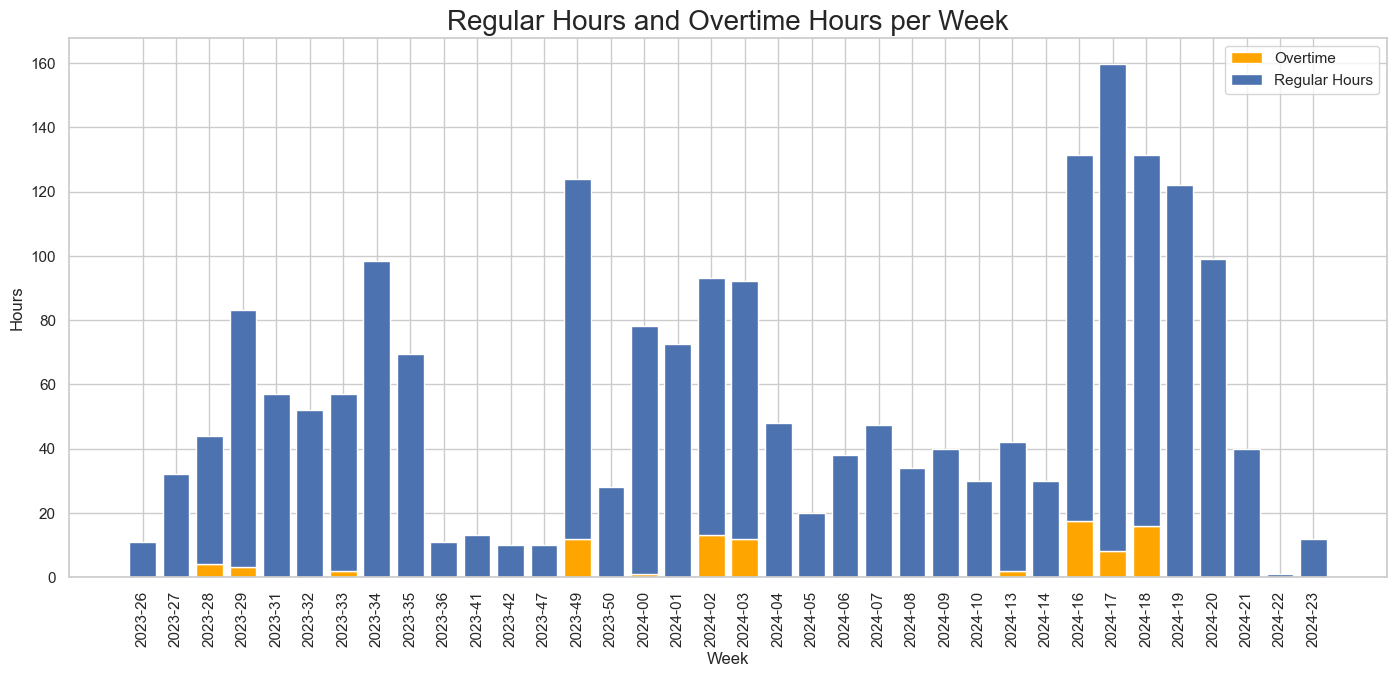

In [68]:
# ------------------------------------Plotting Overtime and regular hours per week-------------------------------------
plt.figure(figsize=(17, 7))

# Plot regular hours and overtime hours
plt.bar(weekly_aggregate['Weeks'], weekly_aggregate['overtime'], label='Overtime',color='orange')
plt.bar(weekly_aggregate['Weeks'], weekly_aggregate['regular_hours'], bottom=weekly_aggregate['overtime'], label='Regular Hours')

# Add labels and title
plt.xlabel('Week')
plt.ylabel('Hours')
plt.title('Regular Hours and Overtime Hours per Week', fontsize = 20)
plt.xticks(weekly_aggregate['Weeks'],rotation=90)
plt.legend()
# plt.tight_layout()
# Show plot

plt.show()

<center>During Phase 4 only 11 weeks had overtime hours in them, none of them with a significant amount of OT hours<center>

-------------------

## Regular hours and Overtime distribution
Here we can see what percentage of total hours was regular hours and overtime hours


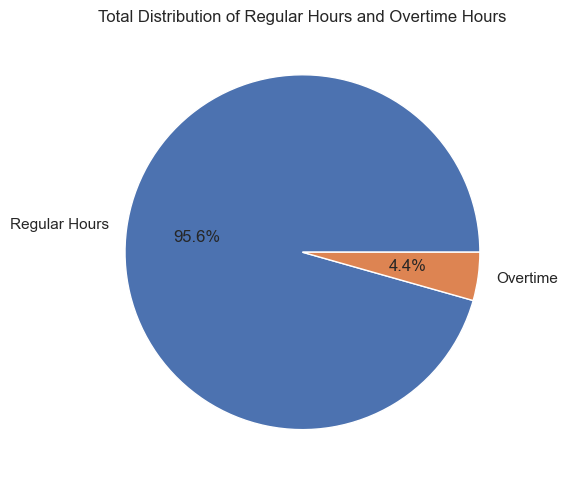

In [69]:
#Calculate regular hours and overtime hours
total_regular_hours = weekly_df['regular_hours'].sum()
total_overtime = weekly_df['overtime'].sum()

# Plotting
fig, ax = plt.subplots(figsize=(7, 5))
ax.pie([total_regular_hours, total_overtime], labels=['Regular Hours', 'Overtime'], autopct='%1.1f%%')
ax.set_title('Total Distribution of Regular Hours and Overtime Hours')
plt.tight_layout()
# Show plot
plt.show()

<center>Less than 5 percent of the Total human hours were OT hours, this is a great ratio of OT to regular hours<center>

------------------------

## Weekly Overtime hours and Regular hours per Employee

On this section we can display the amount of regular hours and overtime hours per employee, this is extremely important when calculating the human labor cost, given that each worker makes earns a different wage, we can send this table to the accounting department where they can get the final human labor cost for this Phase

In [70]:
# Aggregate by 'week' to get the total regular_hours and overtime
weekly_emp = weekly_df.groupby('Employee')[['regular_hours','overtime']].sum().reset_index()

weekly_emp.style

,Employee,regular_hours,overtime
0,Azael Santos,490.500000,15.500000
1,Brea Mc Lellan,57.000000,0.000000
2,Chas,3.000000,0.000000
3,David Aceituno,645.000000,20.000000
4,Janice,40.000000,17.500000
5,Malekey Boddie,193.500000,16.000000
6,Mike Cluett,316.000000,21.500000
7,Neil Wolthers,65.000000,0.000000
8,Tim Bargen,160.750000,0.000000


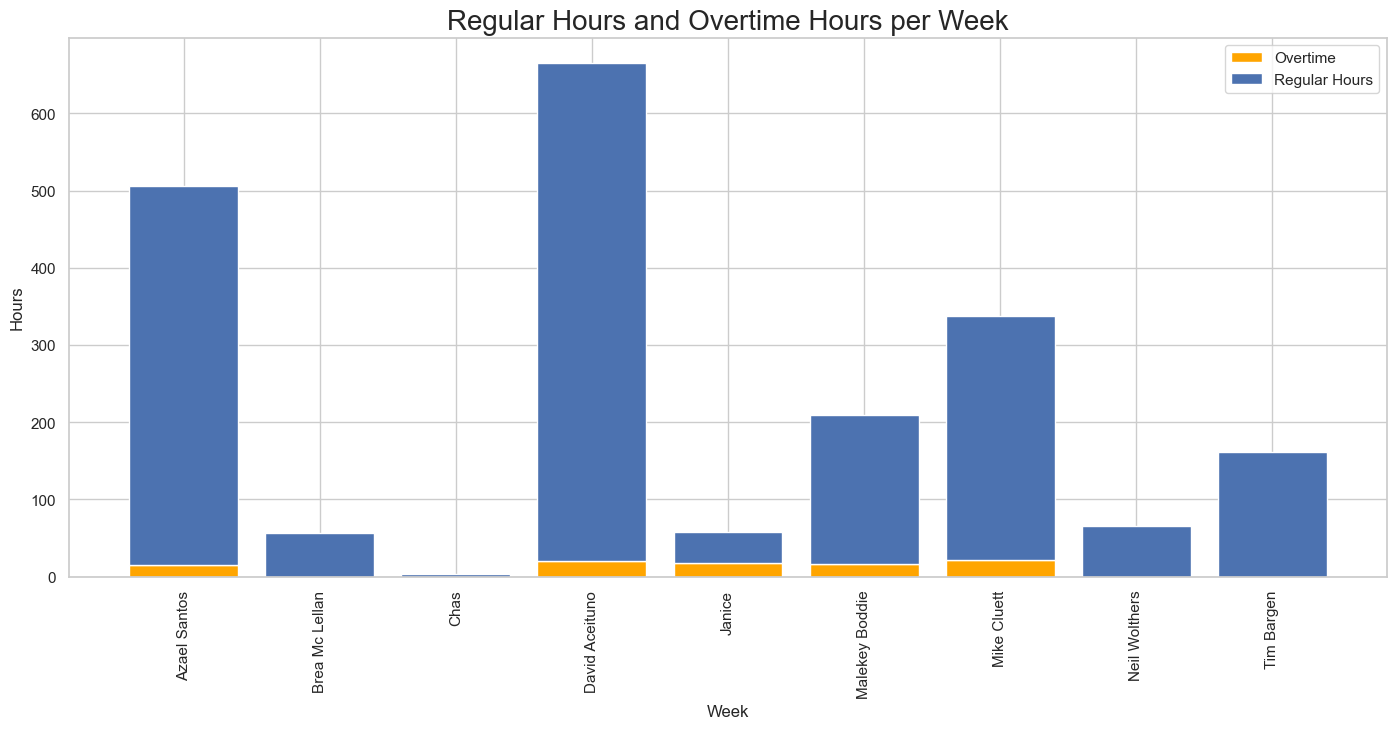

In [71]:
# Plotting
plt.figure(figsize=(17, 7))

# Plot regular hours and overtime hours
plt.bar(weekly_emp['Employee'], weekly_emp['overtime'], label='Overtime',color='orange')
plt.bar(weekly_emp['Employee'], weekly_emp['regular_hours'], bottom=weekly_emp['overtime'], label='Regular Hours')

# Add labels and title
plt.xlabel('Week')
plt.ylabel('Hours')
plt.title('Regular Hours and Overtime Hours per Week', fontsize = 20)
plt.xticks(weekly_emp['Employee'],rotation=90)
plt.legend()
# plt.tight_layout()
# Show plot
plt.show()

<center>Most of the workers had OT hours and the number of OT hours was similar, as expected<center>

--------------------

## Overtime and Regular Hours per Task

On this section of the analysis, we can visualize the number of regular hours and overtime hours per task, that will give us a better idea on how to manage each task in any future project

In [72]:
# Aggregate by 'task' to get the total regular_hours and overtime
task_aggregate = weekly_df.groupby('Task')[['regular_hours','overtime']].sum().reset_index()

#Print task_aggregate table
task_aggregate.style

,Task,regular_hours,overtime
0,Concrete Floor,124.000000,7.000000
1,Drywall,634.750000,28.000000
2,Insulation,40.000000,0.000000
3,Interior Framing,486.000000,14.000000
4,Plumbing,39.000000,0.000000
5,Prime and Touch ups,647.000000,41.500000


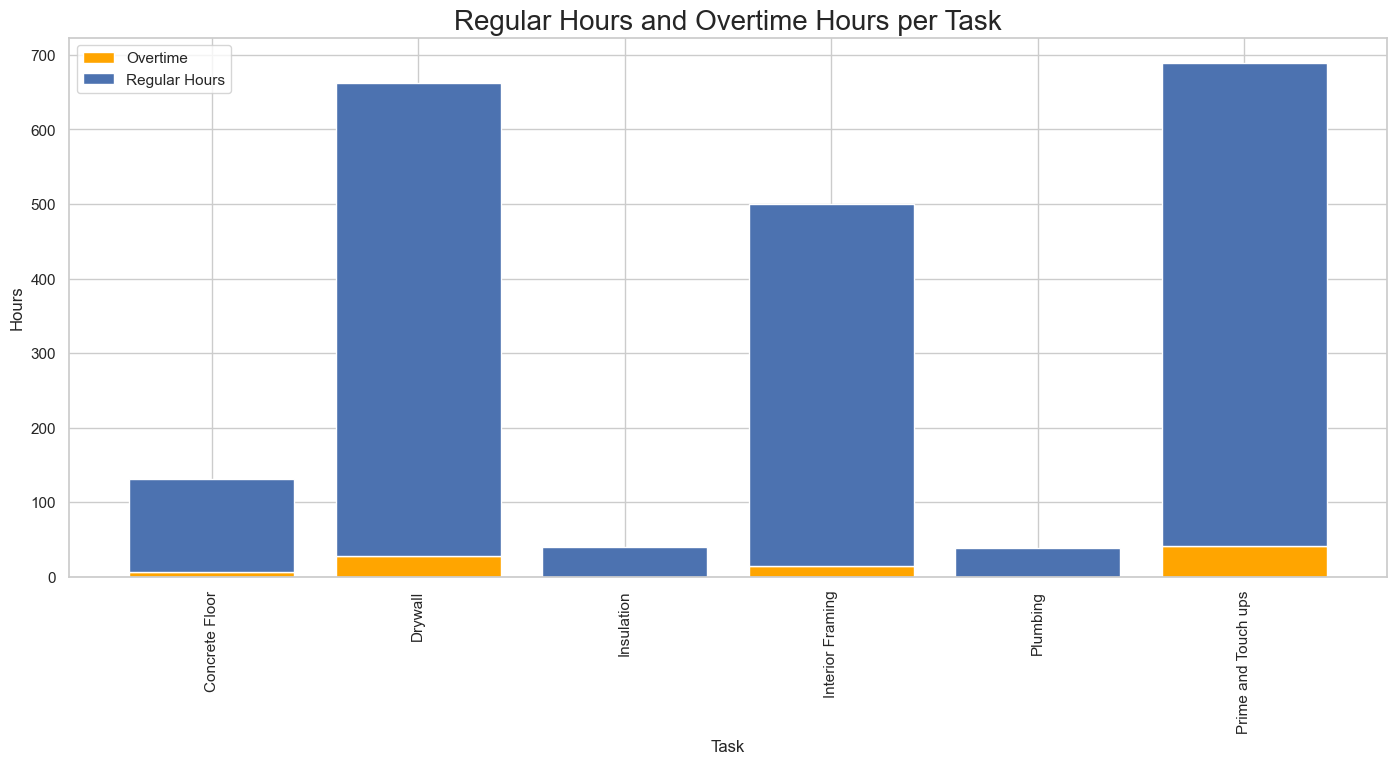

In [73]:
# Plotting
plt.figure(figsize=(17, 7))

# Plot regular hours and overtime hours
plt.bar(task_aggregate['Task'], task_aggregate['overtime'], label='Overtime',color='orange')
plt.bar(task_aggregate['Task'], task_aggregate['regular_hours'], bottom=task_aggregate['overtime'], label='Regular Hours')

# Add labels and title
plt.xlabel('Task')
plt.ylabel('Hours')
plt.title('Regular Hours and Overtime Hours per Task', fontsize = 20)
plt.xticks(task_aggregate['Task'],rotation=90)
plt.legend()
# plt.tight_layout()
# Show plot
plt.show()

<center>Out of all the tasks, the 'Prime and Touch ups' task had the Most amount of OT ad Regula hours<center>

----------------

### Conclusion

In this phase, we saw a marked decrease in overtime hours compared to Phase 3, signifying a more balanced and effective allocation of workload among team members. This reduction in overtime suggests that tasks were completed more efficiently within regular working hours.

Moreover, there was a notable reduction in the overlap between tasks, which led to a more organized and streamlined workflow. This minimized the delays and bottlenecks that often arise from task overlaps, allowing team members to focus more clearly on their individual responsibilities.

Despite these enhancements in efficiency and task management, the overall length of this phase was comparable to that of Phase 3. This indicates that our team maintained the same project timeline while optimizing the use of available time. The improvements in reducing overtime and task overlap reflect a strategic shift towards better process management and resource utilization.

These findings underscore a significant advancement in our operational efficiency, suggesting that the team’s improved time and task management can serve as a model for future phases. Moving forward, continuing to refine these practices will be key to sustaining and enhancing our productivity and project outcomes.